In [17]:
import random as rd
import math
import numpy as np
import numpy.random as nprd
%matplotlib inline
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import scipy
pd.options.mode.chained_assignment = None 

In [143]:
def get_checkouts(checkout_line_to_test, simulations_use, exp_line = None):
    """
    given checkout_line object and lit of tests to run, returns object after running all simulaitons 
    corresponding to ones in the list
    
    
    """
    
    if 1 in simulations_use:
        checkout_line_to_test.checkout_1()

    if 2 in simulations_use:
        checkout_line_to_test.checkout_2()
    
    if 3 in simulations_use:
        checkout_line_to_test.checkout_3()
        
    if 4 in simulations_use:
        checkout_line_to_test.checkout_4(exp_line)
        
    if 5 in simulations_use:
        checkout_line_to_test.checkout_5(exp_line)
    
    return checkout_line_to_test

def arrivals(events, rate, numb_samples):
    y = nprd.gamma(events,rate,numb_samples)
    return y

def items(trials, prob_of_success, numb_samples):
    y = nprd.negative_binomial(trials, prob_of_success, numb_samples)
    return y

def processing_time(constant_waiting, item_waiting, list_items):
    """
    For each set of items in list_item 
    Calculates processing time as: procssing time = const_waiting + item_waiting*number_of_items
    """
    y = list(item_waiting*np.array(list_items) + constant_waiting)
    return y





In [94]:
class checkout_line:
    """
    An object which accounts for a line up to the checkout
    
    Uses negative binomial distribution for number of items, with inital item purchase goal (r), and 
    probability of buying other items (p)
    
    Assumes a poisson process with average rate of arrival (lamb)
    
    cw    = Real number representing minimum wait time for processing 
    pw    = Real number representing per item waiting time for processing
    piw   = cw + pw*p*r/(1-p) (average processing time)
    items = average number of items purchased
    df    = dataframe with results from simulations
    dfa   = dataframe with sumamry statistics of simulations run on object
    
    """
    
    def __init__(self, const_processing_time, per_item_processing_time, rate_arrival, \
                 prob_of_other_buys, initial_item):
        
        self.p = 1 - prob_of_other_buys
        self.r = initial_item
        self.items = self.r*self.p/(1-self.p) + self.r
        self.cw = const_processing_time
        self.pw = per_item_processing_time
        self.piw = self.cw + self.pw*self.items
        
        if 1/rate_arrival > self.cw + self.items*self.piw:
            print('Warning: stability is not possible')
        
        self.lamb = rate_arrival
        columns_use = ["checkout_type", "num_observations","const_processing_time","per_item_processing_time",\
                       "prob_other_buys", "initial_item","arrival_rate","express_line" ,"avg_wait", \
                       "max_wait", "std_wait"]
        self.dfa = pd.DataFrame(pd.np.empty((0, 11)), columns=columns_use)
        
        

    
    def create_timeseires(self, numb_samples):
        
        """
        Takes random variable paramters in checkout_line object and number of samples wanted (numb_samples) and outputs
        coresponding dataframe, with columns associted with; time of arrival, number of items, processing time, time 
        of exit, waiting time, cashier (final three columns filled with NaN)
        
        n = number of samples to create in timeseries
        
        
        """
        
        self.n = numb_samples
        #Datarame for all arrials
        matrix = pd.DataFrame(np.zeros((self.n, 6)), columns=["time_arrive", "num_items", \
                                                              "processing_time","time_left", "waiting_time", "cashier"])
        
        #Setting up number of itmes for all samples
        matrix["num_items"] = items(self.r,self.p, self.n) + self.r
        
        #Setting up processing time for all samples
        matrix["processing_time"] = processing_time(self.cw, self.pw, matrix["num_items"])

        #Setting up arrival time for all samples
        matrix["time_arrive"] = arrivals(1,1/self.lamb, self.n)
        matrix["time_arrive"] = matrix["time_arrive"].cumsum()
        
        self.df = matrix
    
    def update_results(self, checkout_type, expres = None):
        """
        Takes results from checkout simulation in results_df and adds summary statistics to annalysis_df, accounting for
        where or not an express checkout was used.

        If express checkout was used then add the number of item limit number for express checkout. If no express checkout,
        then will be set as Nonetype
        """
        
        #calcualte acerage, max, and standard deviation of waiting time, as well as number of observation
        average_wait = self.df["waiting_time"].mean()
        max_wait = self.df["waiting_time"].max()
        std_wait = self.df["waiting_time"].std()
        n = self.df["waiting_time"].shape[0]
        
        #create new row to add to summary
        new_row = pd.DataFrame({"checkout_type":[checkout_type], "num_observations":[n],
                               "prob_other_buys":[1-self.p],"const_processing_time":[self.cw], 
                               "per_item_processing_time":[self.pw], "arrival_rate":[self.lamb],
                               "express_line":[expres],"avg_wait":[average_wait], 
                                "max_wait": [max_wait],"std_wait": [std_wait], "initial_item": [self.r]})
        
        #add new row to summary dataframe
        self.dfa = pd.concat([self.dfa, new_row])

    def checkout_1(self):
        """
        Checkout system with one line, 5 cashiers, and first person in line goes to cashier with none at it

        """
        #start off with all checkouts being empty
        cashiers_open = [0,0,0,0,0]
        mat = self.df

        for i in range(0,self.n):
            #if there are empty cashiers
            if (mat[i:i+1:]["time_arrive"]).iloc[0] > min(cashiers_open):

                #time left = timea arrival + prcoessing time = next time this cashier will be open
                a = mat[i:i+1:]["time_arrive"].iloc[0] + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a
                min_waiting_cashier = cashiers_open.index(min(cashiers_open)) #index of open cashier
                mat[i:i+1:]["cashier"].iloc[0] = min_waiting_cashier + 1 #recording which cashier used
                cashiers_open[min_waiting_cashier] = a

                #waiting time is the same as processing time
                mat[i:i+1:]["waiting_time"].iloc[0] = mat[i:i+1:]["processing_time"].iloc[0]

            #if there are no empty cashier
            else:
                #time left is time earliest cashier to open + processing time
                a =  min(cashiers_open) + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a
                min_waiting_cashier = cashiers_open.index(min(cashiers_open)) #index of earliest open cashier
                mat[i:i+1:]["cashier"].iloc[0] = min_waiting_cashier + 1 #recording which cashier used
                cashiers_open[min_waiting_cashier] = a

                #waiting time is the difference between time fo arrival and time left
                mat[i:i+1:]["waiting_time"].iloc[0] = a - mat[i:i+1:]["time_arrive"].iloc[0]
        
        self.df = mat
        self.update_results("checkout_1")
        
    
    def checkout_2(self):
        """
        Checkout system with 5 line, 5 cashiers, and person arrives goes to cashier with min number people in line

        """
        #start off with all checkouts being empty
        cashiers_open = [0,0,0,0,0]
        cashier_times = [[0],[0],[0],[0],[0]]
        mat = self.df

        for i in range(0,self.n):
            #looking at who is in line
            temp = mat[:i:]
            arrive_time = mat[i:i+1:]["time_arrive"].iloc[0]
            current_line = temp[temp["time_left"] > arrive_time]
            waiting_customers = current_line["cashier"]

            #count how many people are in each line
            cashiers_open = [sum(waiting_customers == 1),sum(waiting_customers == 2),\
            sum(waiting_customers == 3), sum(waiting_customers == 4), sum(waiting_customers == 5)]

            #set cashier based on cashier with min people in line
            min_waiting_cashier = cashiers_open.index(min(cashiers_open)) #index of min people in line
            cashier = min_waiting_cashier + 1 #recording which cashier used
            mat[i:i+1:]["cashier"].iloc[0] =  cashier


            #if there are empty cashiers
            if 0 == min(cashiers_open):
                #time left = timea arrival + prcoessing time = next time this cashier will be open
                a = arrive_time + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the same as processing time
                mat[i:i+1:]["waiting_time"].iloc[0] = mat[i:i+1:]["processing_time"].iloc[0]

            #if there are no empty cashier 
            else:
                #time left = time person in front at cashier left + processing time
                in_front_left = max(current_line[current_line["cashier"] == cashier]["time_left"])
                a =  in_front_left + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the difference between time fo arrival and time left
                mat[i:i+1:]["waiting_time"].iloc[0] = a - mat[i:i+1:]["time_arrive"].iloc[0]
        
        self.df = mat
        self.update_results("checkout_2")
    
    def checkout_3(self):
        """
        Checkout system with 5 line, 5 cashiers, and  each customer randomly selects a line upon arrival at the checkout.

        """
        #start off with all checkouts being empty
        cashiers_open = [0,0,0,0,0]
        cashier_times = [[0],[0],[0],[0],[0]]
        mat = self.df

        for i in range(0,self.n):
            #looking at who is in line
            temp = mat[:i:]
            arrive_time = mat[i:i+1:]["time_arrive"].iloc[0]
            current_line = temp[temp["time_left"] > arrive_time]
            waiting_customers = current_line["cashier"]


            #set cashier based on sampling from descrete uniform distribution between 1 and 5 (closed)
            cashier = np.random.randint(1,6,size=1)[0] #index of cashier chosen and recording it
            mat[i:i+1:]["cashier"].iloc[0] =  cashier

            #if cashier is empty
            if 0 == sum(waiting_customers == cashier):
                #time left = timea arrival + prcoessing time = next time this cashier will be open
                a = arrive_time + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the same as processing time
                mat[i:i+1:]["waiting_time"].iloc[0] = mat[i:i+1:]["processing_time"].iloc[0]

            #if cashier is not empty
            else:
                #time left = time person in front at cashier left + processing time
                in_front_left = max(current_line[current_line["cashier"] == cashier]["time_left"])
                a =  in_front_left + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the difference between time fo arrival and time left
                mat[i:i+1:]["waiting_time"].iloc[0] = a - mat[i:i+1:]["time_arrive"].iloc[0]
        
        self.df = mat
        self.update_results("checkout_3")
    
    def checkout_4(self, exp_items):
        """
        Checkout system with 4 standard lines, 1 express line (10 prodcuts or less). 

        Upon arrival each customer with more then exp_items items go to the line with least people and 
        to the express line otherwise .

        """
        #start off with all checkouts being empty
        cashiers_open = [0,0,0,0,0]
        cashier_times = [[0],[0],[0],[0],[0]]
        mat = self.df

        for i in range(0,self.n):
            #looking at who is in line
            temp = mat[:i:]
            arrive_time = mat[i:i+1:]["time_arrive"].iloc[0]
            current_line = temp[temp["time_left"] > arrive_time]
            waiting_customers = current_line["cashier"]

            #count how many customers are in each line and which line has least customers
            cashiers_open = [sum(waiting_customers == 1),sum(waiting_customers == 2),\
            sum(waiting_customers == 3), sum(waiting_customers == 4), sum(waiting_customers == 5)]


            #checking whether will use expres line otherwise will use line with min customers waiting
            cashier = 1
            num_items = mat[i:i+1:]["num_items"].iloc[0]
            if num_items > exp_items:
                #set cashier based on cashier with min people in line that is not an express cashier
                non_express_lines = cashiers_open[1:]
                min_waiting_cashier = non_express_lines.index(min(non_express_lines)) + 1 #index of wanted cashier
                cashier = min_waiting_cashier + 1 #recording which cashier used

            #set cashier that will be used
            mat[i:i+1:]["cashier"].iloc[0] =  cashier

            #if cashier is empty
            if 0 == sum(waiting_customers == cashier):
                #time left = timea arrival + prcoessing time = next time this cashier will be open
                a = arrive_time + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the same as processing time
                mat[i:i+1:]["waiting_time"].iloc[0] = mat[i:i+1:]["processing_time"].iloc[0]

            #if there are cashier is not empty
            else:
                #time left = time person in front at cashier left + processing time
                in_front_left = max(current_line[current_line["cashier"] == cashier]["time_left"])
                a =  in_front_left + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the difference between time fo arrival and time left
                mat[i:i+1:]["waiting_time"].iloc[0] = a - mat[i:i+1:]["time_arrive"].iloc[0]
        
        self.df = mat
        self.update_results("checkout_4", exp_items)
    
    def checkout_5(self, exp_items):
        """
        Checkout system with 4 standard lines, 1 express line (10 prodcuts or less). 

        Upon arrival each customer with more then exp_items items go to the line with least people or 
        to the express line if customer has less then exp_items and the express line has the least custmers in line .

        """
        #start off with all checkouts being empty
        cashiers_open = [0,0,0,0,0]
        cashier_times = [[0],[0],[0],[0],[0]]
        mat = self.df

        for i in range(0,self.n):

            #looking at who is in line
            temp = mat[:i:]
            arrive_time = mat[i:i+1:]["time_arrive"].iloc[0]
            current_line = temp[temp["time_left"] > arrive_time]
            waiting_customers = current_line["cashier"]

            #count how many customers are in each line and which line has least customers
            cashiers_open = [sum(waiting_customers == 1),sum(waiting_customers == 2),\
            sum(waiting_customers == 3), sum(waiting_customers == 4), sum(waiting_customers == 5)]
            min_waiting_cashier = cashiers_open.index(min(cashiers_open)) #index of min people in line

            #checking whether will use expres line or line with min customers waiting
            cashier = 1
            num_items = mat[i:i+1:]["num_items"].iloc[0]
            if num_items > exp_items or \
            (num_items <= exp_items and cashiers_open[0] > cashiers_open[min_waiting_cashier]):
                #set cashier based on cashier with min people in line that is not an express cashier
                non_express_lines = cashiers_open[1:]
                min_waiting_cashier = non_express_lines.index(min(non_express_lines)) + 1 #index of wanted cashier
                cashier = min_waiting_cashier + 1 #recording which cashier used

            #set cashier that will be used
            mat[i:i+1:]["cashier"].iloc[0] =  cashier


            #if cashier is empty
            if 0 == sum(waiting_customers == cashier):
                #time left = timea arrival + prcoessing time = next time this cashier will be open
                a = arrive_time + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the same as processing time
                mat[i:i+1:]["waiting_time"].iloc[0] = mat[i:i+1:]["processing_time"].iloc[0]

            #if there are cashier is not empty
            else:
                #time left = time person in front at cashier left + processing time
                in_front_left = max(current_line[current_line["cashier"] == cashier]["time_left"])
                a =  in_front_left + mat[i:i+1:]["processing_time"].iloc[0]
                mat[i:i+1:]["time_left"].iloc[0] = a

                #waiting time is the difference between time fo arrival and time left
                mat[i:i+1:]["waiting_time"].iloc[0] = a - mat[i:i+1:]["time_arrive"].iloc[0]
        
        self.df = mat
        self.update_results("checkout_5", exp_items)

In [140]:
c1 = checkout_line(const_processing_time=1, per_item_processing_time=0.03, initial_item = 5, prob_of_other_buys= 0.6, 
              rate_arrival = 4 )

c1.create_timeseires(100)

In [219]:


def run_simulations(const_processing_time_min, prob_of_other_buys, models_to_use,\
                    per_item_processing_time_min, rate_arrival_min, \
                    initial_item_min,  simulations_num, checkout_orig = None, exp_line_max = None, exp_line_min = 10, \
                    variation_times = 3, const_processing_time_max = None,\
                    rate_arrival_max = None, per_item_processing_time_max = None, initial_item_max = None):
    """
    Paratmers (All in integers or real numbers):
    Given initial paramter that will remain constant for simluations; prob_of_other_buys
    
    Given min and max boundaries for variables which will be analyze; rate_arrival, intial_item, per_item _processing,
    const_processing_time
    
    Given how many iteration to run for each simualtions (simulations_num) 
    
    Simulations:
    Gien how many values to run each simulations at between each max and min value for each paramter, including
    boundary values (variation_times). This works only for values take Real values. Leave empty if no variations.
    
    Given list of numbers corresponding to which models to use
    
    Given checkoutline_object checkout_orig object, will update add information from dfa 
    dataframe of checkout_orig to new checkout object
    
    Note: if not varying any of 3 variable paramters, only input min value
    
    Outputs: Checkoutline_object
    
    
    """
    
    
    #setting up max = min if no max entered
    rate_arrival_max             = rate_arrival_max or rate_arrival_min
    initial_item_max             = initial_item_max  or initial_item_min
    per_item_processing_time_max = per_item_processing_time_max or per_item_processing_time_min
    const_processing_time_max    = const_processing_time_max or const_processing_time_min
    exp_line_max                 = exp_line_max or exp_line_min
    loops = []
    
    variation_times_const, variation_times_per_item = variation_times , variation_times 
    
    #checking if varying contant processing time
    if const_processing_time_min == const_processing_time_max:
        variation_times_const = 1
        variation_times_const_2 = 2
    else:
        variation_times_const_2 = variation_times - 1
        
    #checking if varying per item processing time
    if per_item_processing_time_min == per_item_processing_time_max:
        variation_times_per_item = 1
        variation_times_per_item_2 = 1
    else:
        variation_times_per_item_2 = variation_times - 1
        
    k = 0
    for rate in range(rate_arrival_min, rate_arrival_max +1):
        for items in range(initial_item_min, initial_item_max+1):
             for exp_line in range(exp_line_min, exp_line_max+1):
                for j in range(0,variation_times_const):
                    const_p = const_processing_time_min*(1 - j/variation_times_const_2) \
                    + const_processing_time_max*(j/variation_times_const_2)

                    for i in range(0,variation_times_per_item):

                        per_i_p = (per_item_processing_time_min*(variation_times_per_item_2 - i) + \
                                   per_item_processing_time_max*(i))/(variation_times_per_item_2)
                        
                        check_me_out = checkout_line(const_p, per_i_p, rate, prob_of_other_buys, items)
                        
                        check_me_out.create_timeseires(simulations_num)
                        check_me_out = get_checkouts(check_me_out, models_to_use, exp_line)
                        k += 1
                        print(k)
                        if checkout_orig != None:
                            checkout_orig.dfa = pd.concat([checkout_orig.dfa, check_me_out.dfa])
                        else:
                            checkout_orig = check_me_out
    check_me_out.dfa = pd.concat([checkout_orig.dfa, check_me_out.dfa])
    return check_me_out   

In [220]:
c2 = run_simulations(const_processing_time_min = 1, prob_of_other_buys = 0.6, models_to_use = [1,2,3,4,5],\
                    per_item_processing_time_min = 0.03, per_item_processing_time_max = 0.06, rate_arrival_min = 4, \
                    initial_item_min = 5,  simulations_num = 100, variation_times = 10)

1
2
3
4
5
6
7
8
9
10


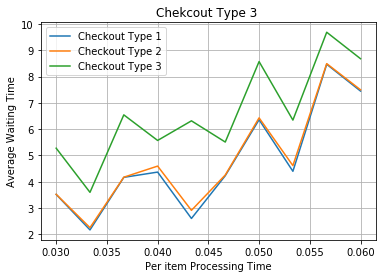

In [240]:
a = c2.dfa
check_1_x = np.asarray(a[a["checkout_type"] == "checkout_1"]["per_item_processing_time"])
check_1_y = np.asarray(a[a["checkout_type"] == "checkout_1"]["avg_wait"])
check_2_x = np.asarray(a[a["checkout_type"] == "checkout_2"]["per_item_processing_time"])
check_2_y = np.asarray(a[a["checkout_type"] == "checkout_2"]["avg_wait"])
check_3_x = np.asarray(a[a["checkout_type"] == "checkout_3"]["per_item_processing_time"])
check_3_y = np.asarray(a[a["checkout_type"] == "checkout_3"]["avg_wait"])

plt.plot(check_1_x, check_1_y, label='Checkout Type 1')
plt.plot(check_2_x, check_2_y, label='Checkout Type 2')
plt.plot(check_3_x, check_3_y, label='Checkout Type 3')

plt.xlabel('Per item Processing Time')
plt.ylabel('Average Waiting Time')
plt.title('Chekcout Type 3 ')
plt.grid(True)
plt.legend()
plt.savefig("test.png")
plt.show()

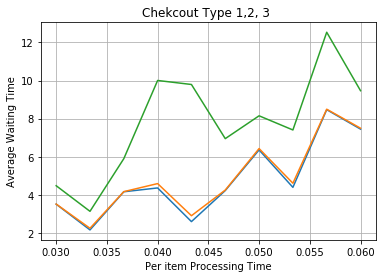

In [236]:
a = c2.dfa
check_1_x = np.asarray(a[a["checkout_type"] == "checkout_1"]["per_item_processing_time"])
check_1_y = np.asarray(a[a["checkout_type"] == "checkout_1"]["avg_wait"])
check_2_x = np.asarray(a[a["checkout_type"] == "checkout_2"]["per_item_processing_time"])
check_2_y = np.asarray(a[a["checkout_type"] == "checkout_2"]["avg_wait"])
check_4_x = np.asarray(a[a["checkout_type"] == "checkout_4"]["per_item_processing_time"])
check_4_y = np.asarray(a[a["checkout_type"] == "checkout_4"]["avg_wait"])

plt.plot(check_1_x, check_1_y, label='Checkout Type 1')
plt.plot(check_2_x, check_2_y, label='Checkout Type 2')
plt.plot(check_4_x, check_4_y, label='Checkout Type 4')
plt.xlabel('Per item Processing Time')
plt.ylabel('Average Waiting Time')
plt.title('Chekcout Type 1,2, 3 ')
plt.grid(True)
plt.savefig("test.png")
plt.show()

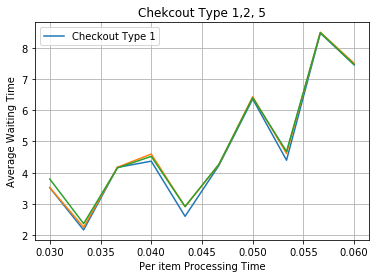

In [239]:

a = c2.dfa
check_1_x = np.asarray(a[a["checkout_type"] == "checkout_1"]["per_item_processing_time"])
check_1_y = np.asarray(a[a["checkout_type"] == "checkout_1"]["avg_wait"])
check_2_x = np.asarray(a[a["checkout_type"] == "checkout_2"]["per_item_processing_time"])
check_2_y = np.asarray(a[a["checkout_type"] == "checkout_2"]["avg_wait"])
check_5_x = np.asarray(a[a["checkout_type"] == "checkout_5"]["per_item_processing_time"])
check_5_y = np.asarray(a[a["checkout_type"] == "checkout_5"]["avg_wait"])
plt.plot(check_1_x, check_1_y, label='Checkout Type 1')
plt.plot(check_2_x, check_2_y, label='Checkout Type 2')
plt.plot(check_5_x, check_5_y, label='Checkout Type 5')
plt.xlabel('Per item Processing Time')
plt.ylabel('Average Waiting Time')
plt.title('Chekcout Type 1,2, 5')
plt.legend()
plt.grid(True)
plt.savefig("test.png")
plt.show()

In [ ]:
(const_processing_time_min = 1, prob_of_other_buys = 0.6, models_to_use = [1,2,3,4,5],\
                    per_item_processing_time_min = 0.03,per_item_processing_time_max = 0.05, rate_arrival_min = 4, \
                    rate_arrival_max = 7, initial_item_min = 5,  simualitons_num = 100 ,\
                    const_processing_time_max = None, exp_line_min = 8, exp_line_max = 12, \
                    initial_item_max = 9)

In [180]:
c2.dfa

,arrival_rate,avg_wait,checkout_type,const_processing_time,express_line,initial_item,max_wait,num_observations,per_item_processing_time,prob_other_buys,std_wait
0,4.0,2.295592,checkout_1,1.0,None,5.0,3.492322,100.0,0.03,0.6,0.606031
0,4.0,2.403907,checkout_2,1.0,None,5.0,4.076183,100.0,0.03,0.6,0.736297
0,4.0,4.322303,checkout_3,1.0,None,5.0,10.029521,100.0,0.03,0.6,2.464153
0,4.0,4.107288,checkout_4,1.0,10,5.0,14.850044,100.0,0.03,0.6,3.265088
0,4.0,2.923135,checkout_5,1.0,10,5.0,5.257138,100.0,0.03,0.6,1.104535
